## Neural Likelihood-to-Evidence Ratio Estimation

_Authors: Paul Bürkner, Lars Kühmichel, Stefan T. Radev_

## Introduction

In this notebook, we will explain how to perform likelihood-to-evidence ratio estimation using the NRE-C method of Miller et al. (2022; https://arxiv.org/abs/2210.06170). Since the likelihood-to-evidence ratio is proportional to the likelihood, we can use estimates of the former as replacement of the likelihood in self-normalizing sampling procedures, for example, in MCMC. Compared to full likelihood estimation, likelihood-to-evidence ratio estimation just requires a simple classification network for estimation, not a generative network. 

In [1]:
import bayesflow as bf
import keras

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

Defaulting to JAX.
To override, set the KERAS_BACKEND environment variable before importing bayesflow.
See: https://keras.io/getting_started/#configuring-your-backend
INFO:2026-02-03 15:54:48,003:jax._src.xla_bridge:834: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:bayesflow:Using backend 'jax'


## Generative Model

We will use a simple **normal means** model as an example. Let the (unknown) mean be $\theta \in \mathbb{R}$, and assume i.i.d. observations
$$
x_i \mid \theta \sim \mathcal{N}(\theta, \sigma^2), \quad i=1,\dots,N,
$$
with known $\sigma$. We also place a prior on $\theta \sim p(\theta)$ ($\text{e.g. } \mathcal{N}(0,\tau^2)$), but this "prior" simply determines the validity scope of the ratio estimator.

Our goal is Bayesian inference for $\theta$ given data $x_{1:n}$, but we will approach it via **neural ratio estimation (NRE)**. Concretely, we will use **contrastive neural ratio estimation** (NRE-C), which learns the **likelihood-to-evidence ratio**
$$
r(\theta, x) \;=\; \frac{p(x\mid \theta)}{p(x)}
$$
by training a classifier on simulated pairs $(\theta, x)$. NRE-C is a multiclass/contrastive formulation designed to avoid the bias term issues that can arise in earlier multiclass NRE variants ()

Concretely, we simulate from the model:
1. Sample $\theta \sim p(\theta)$
2. Sample $x \sim p(x\mid \theta)$

Then we train a neural network $s_\phi(\theta, x)$ so that at optimum it recovers the **log-ratio** (up to the usual equivalences of the method):
$$
s_\phi(\theta, x) \approx \log r(\theta, x).
$$

Once we have $\hat r_\phi(\theta, x) = \exp(s_\phi(\theta, x))$, we can form an approximate posterior via
$$
p(\theta\mid x) \propto p(\theta)\,\hat r_\phi(\theta, x).
$$

A very convenient feature in the i.i.d. setting is that the ratio **factorizes** across observations:
$$
\hat{r}(\theta, x_{1:n})
= \frac{p(x_{1:n}\mid \theta)}{p(x_{1:n})}
= \prod_{i=1}^n \frac{p(x_i\mid \theta)}{p(x_i)}
= \prod_{i=1}^n \hat{r}(\theta, x_i).
$$
Taking logs gives the additive form:
$$
\log \hat{r}(\theta, x_{1:n}) = \sum_{i=1}^n \log \hat{r}(\theta, x_i).
$$


Thus, training can be done with *cheap* single-observation simulations, and inference for larger datasets is just a sum of per-observation network outputs.

---

## Reference (NRE-C)

Miller, B. K., Weniger, C., & Forré, P. (2022). *Contrastive Neural Ratio Estimation for Simulation-based Inference*. NeurIPS 2022, arXiv:2210.06170.

In [2]:
def prior():
    mu = np.random.uniform(-10, 10)
    return {"mu": mu}

def likelihood(mu):
    return {"x": mu + np.random.standard_normal()}

In [3]:
simulator = bf.make_simulator([prior, likelihood])

In [4]:
test_sims = simulator.sample(3)
for k, v in test_sims.items():
    print(k, v.shape)

mu (3, 1)
x (3, 1)


## Approximator

The `RatioApproximator`, which implements NRE-C, requires two key variables from the simulator: `inference_variables`, containing the model parameters (here only `mu`), and `inference_conditions`, containing the observables (here only `x`). For convenience, we adapt the simulation outputs with the default adapter.

In [5]:
adapter = bf.approximators.RatioApproximator.build_adapter(
    inference_variables=["mu"], 
    inference_conditions=["x"]
)

We initialize and fit a `RatioApproximator` in pretty much the same way as we do with other approximators in BayesFlow. One important detail is that we don't have an `inference_network` but a `classifier_network`, which can be a simple as an MLP. We could additionally specify a `summary_network` to summarize the observables before passing them to `classifier_network`, but for this simple example, we are completely fine without `summary_network`.

In [6]:
ratio_approximator = bf.approximators.RatioApproximator(
    adapter=adapter,
    classifier_network=bf.networks.MLP(widths=[64, 64]),
    standardize=None
)

In [7]:
ratio_approximator.compile(optimizer="adam")

history = ratio_approximator.fit(
    simulator=simulator,
    epochs=50, 
    num_batches=200, 
    batch_size=32
)

INFO:bayesflow:Building dataset from simulator instance of SequentialSimulator.
INFO:bayesflow:Using 24 data loading workers.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.0264 
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0483 
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9094 
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8690 
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8436 
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8405 
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8360 
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8203 
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8105 
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8261 
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8169 
Epoch 12/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8122 
Epoch 13/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8244 
Epoch 14/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8046 
Epoch 15/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s

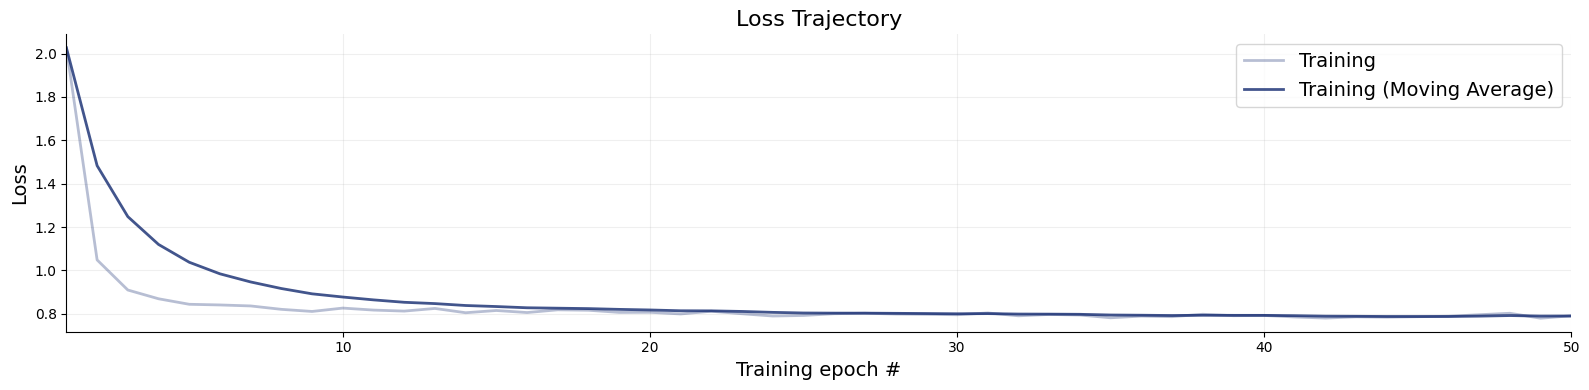

In [9]:
f = bf.diagnostics.plots.loss(history)

The amount of online simulations we used for training was probably quite a bit of an overkill and we would have gotten away with good results also with fewer simulations.

## Results

Let's perform an initial check of the approximator's results by comparing the log_ratio estimates of matching vs. non-matching (`mu`, `x`) pairs. If our ratio approximator has been learning correctly, the matching pairs should have much higher ratios than the non-matching pairs.

In [10]:
sims = simulator.sample(1000)
contrastive_sims = {
    "mu": sims["mu"][::-1],
    "x": sims["x"]
}

In [11]:
log_ratio_positive = keras.ops.convert_to_numpy(ratio_approximator.log_ratio(sims))
log_ratio_negative = keras.ops.convert_to_numpy(ratio_approximator.log_ratio(contrastive_sims))

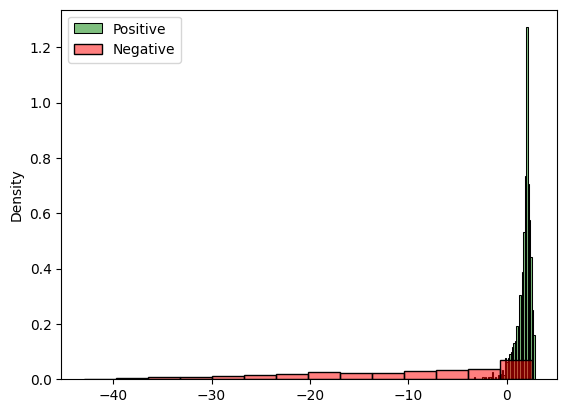

In [12]:
f, ax = plt.subplots(1, 1)
sns.histplot(log_ratio_positive, stat="density", ax=ax, label="Positive", color="green", alpha=0.5)
sns.histplot(log_ratio_negative, stat="density", ax=ax, label="Negative", color="red", alpha=0.5)
ax.legend()

Based on the above histogram, this needs seems to be the case, which is a first sanity check that what the approximator learned goes in the right direction. Let's perform some further tests.

Upon perfect learning of the likelihood-to-evidence ratio, the difference of the log likelihood and the log likelihood-to-evidence ratio should be constant (= log evidence) for any fixed observation. In simple cases, such as our normal means model, we have the analytic likelihood available, so we can easily verify this property. In reality, we of course usually only do likelihood-to-evidence ratio estimation if we don't actually have the likelihood available. Accordingly, bespoke check is more to verify the correctness of the general implementation rather than a practical real-world diagnostic.

In [14]:
def log_lik(x, mu):
    return norm.logpdf(x.squeeze(), loc=mu.squeeze(), scale=1)

We can check the estimated values of the log evidence for any dataset. Here, we simply choose `x=2` and evaluate the log evidence for equally space values of `mu` between -6 and 6, which covers most of the prior range.

In [24]:
mu = np.linspace(-10, 10, 100)[:, np.newaxis]
x_obs = np.array([2])
x_obs_batched = np.repeat(x_obs[np.newaxis, :], mu.shape[0], axis=0)
sims_x_obs = dict(x=x_obs_batched, mu=mu)

ll = log_lik(x_obs_batched, mu)
lr = ratio_approximator.log_ratio(sims_x_obs)
le = ll - lr

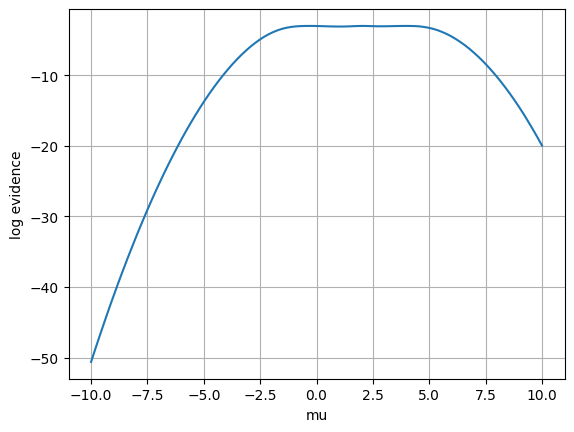

In [25]:
plt.plot(mu, le)
plt.xlabel('mu')
plt.ylabel('log evidence')
plt.grid(True)
plt.show()

The plot indicates that, for most values of the parameter `mu`, the estimated log evidence is indeed roughly the same. However, for parameter values that are quite unlikely to have generated `x=2`, we see some deviation, indicating that the ratio approximator has not yet sufficiently converged there. This is because, during training, these combinations of `mu` and `x` were never seen, so they are out-of-distribution for the ratio approximator, which hence becomes inaccurate there.

## MCMC with NRE

We can easily plug our likelihood-to-evidence ratio approximation into PyMC to run MCMC. This just requires writing a small wrapper around our neural approximator so the input and output structures matches thoses expected by PyMC.

In [17]:
import pymc as pm
import pytensor.tensor as pt
from pytensor.graph import Op, Apply

class RatioOp(Op):
    """
    Op for likelihood-to-evidence approximator: computes p(x|theta) / p(x)
    """
    def __init__(self, ratio_approximator, x_obs):
        """
        ratio_approximator: trained ratio approximator
        x_obs: vector of observations
        """
        self.approximator = ratio_approximator
        self.x_obs = x_obs
        
    def make_node(self, mu):
        mu = pt.as_tensor_variable(mu)
        return Apply(self, [mu], [pt.dscalar()])
    
    def perform(self, node, inputs, outputs):
        mu = inputs[0]
        # broadcast mu to the shape of x_obs
        mu = np.repeat(mu[np.newaxis, :], self.x_obs.shape[0], axis = 0)
        data = dict(x = self.x_obs, mu = mu)
        # results in a vector of log_ratio values; one per element of x_obs
        log_ratio = self.approximator.log_ratio(data)
        outputs[0][0] = np.asarray(np.sum(log_ratio, axis=0), dtype='float64')

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


We instantiate our ratio likelihood with a simulated dataset of 10 observations, all generated by the same true value of `mu`.

In [18]:
x_obs_vector = simulator.sample(10, mu=1)["x"]
ratio_op = RatioOp(ratio_approximator, x_obs=x_obs_vector)

We can now incorporate the ratio likelihood for the given data into a PyMC model and use basic likelihood-based samplers such as slice sampling. 

If we additionally specified a gradient -- which we could with the ratio approximator -- we could even run advanced MCMC algorithms such as Hamiltonian Monte Carlo (HMC) with NUTS. 

For demonstration purposes here, slice sampling is sufficient. We use weakly informative priors below, to better check the effect of the ratio approximator on the resulting posterior. Since the likelihood-to-evidence ratio is independent of the prior, we can use different priors in training and during MCMC inference, something that is not immediate in direct neural posterior estimation.

In [20]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=10, shape=1)
    log_likelihood = ratio_op(mu)
    pm.Potential('log_likelihood', log_likelihood)
    trace = pm.sample(1000, step=pm.Slice(), chains=4, cores=1)

INFO:pymc.sampling.mcmc:Sequential sampling (4 chains in 1 job)
INFO:pymc.sampling.mcmc:Slice: [mu]


Output()

INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

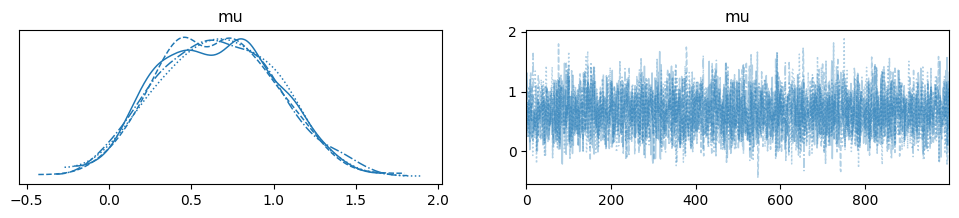

In [21]:
import arviz
arviz.plot_trace(trace)

MCMC sampling took just a few seconds and the estimation posterior looks reasonable. We further verify the posterior's accuracy by comparing it with empirical moments directly obtained from the observed data. Since we used a simple normal means model and uninformative priors, the true posterior mean of `mu` is essentially the empirical mean of the data. The same goes for the posterior standard deviation of `mu`, which is essentially the empirical standard error of the observed data mean. Of course, these special relationships only hold for this simple model.

In [22]:
print(np.mean(trace["posterior"]["mu"]))
print(np.std(trace["posterior"]["mu"]))

<xarray.DataArray 'mu' ()> Size: 8B
array(0.65915859)
<xarray.DataArray 'mu' ()> Size: 8B
array(0.35842967)


In [23]:
print(np.mean(x_obs_vector))
print(np.std(x_obs_vector) / np.sqrt(x_obs_vector.shape[0]))

0.70156017896759
0.32138566631847604


Indeed, MCMC posterior and empirical estimates match well, providing further evidence that our likelihood-to-evidence ratio approximation has been successful.